### Object Detection and Segmentation

A few vision tasks:
- Object Detection: Detects objects with bounding boxes, class labels, and confidence scores.
- Instance Segmentation: Generates pixel-level masks for each detected object.
- Keypoint Detection: Identifies body keypoints (e.g., shoulders, elbows) for pose estimation.
- Image Captioning: Generates a textual description of the scene.

Key Features:
- Mask R-CNN: Adds mask prediction to Faster R-CNN for object detection and segmentation.
- Keypoint R-CNN: Detects human body keypoints.
- BLIP: Generates captions based on image content.
- COCO Dataset: Pre-trained on 80 common object categories.

Outputs:
1. Bounding Boxes: Object boundaries with labels and scores.
2. Masks: Pixel-level segmentation for each object.
3. Keypoints: Human body joint localization.
4. Caption: Descriptive text summarizing the scene.

In [35]:
image_url = 'https://d36tnp772eyphs.cloudfront.net/blogs/1/2019/03/Traditional-teahouse-in-the-strrets-of-Calcutta.jpg'

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments oth

Caption: two men in a kitchen with pots and pans


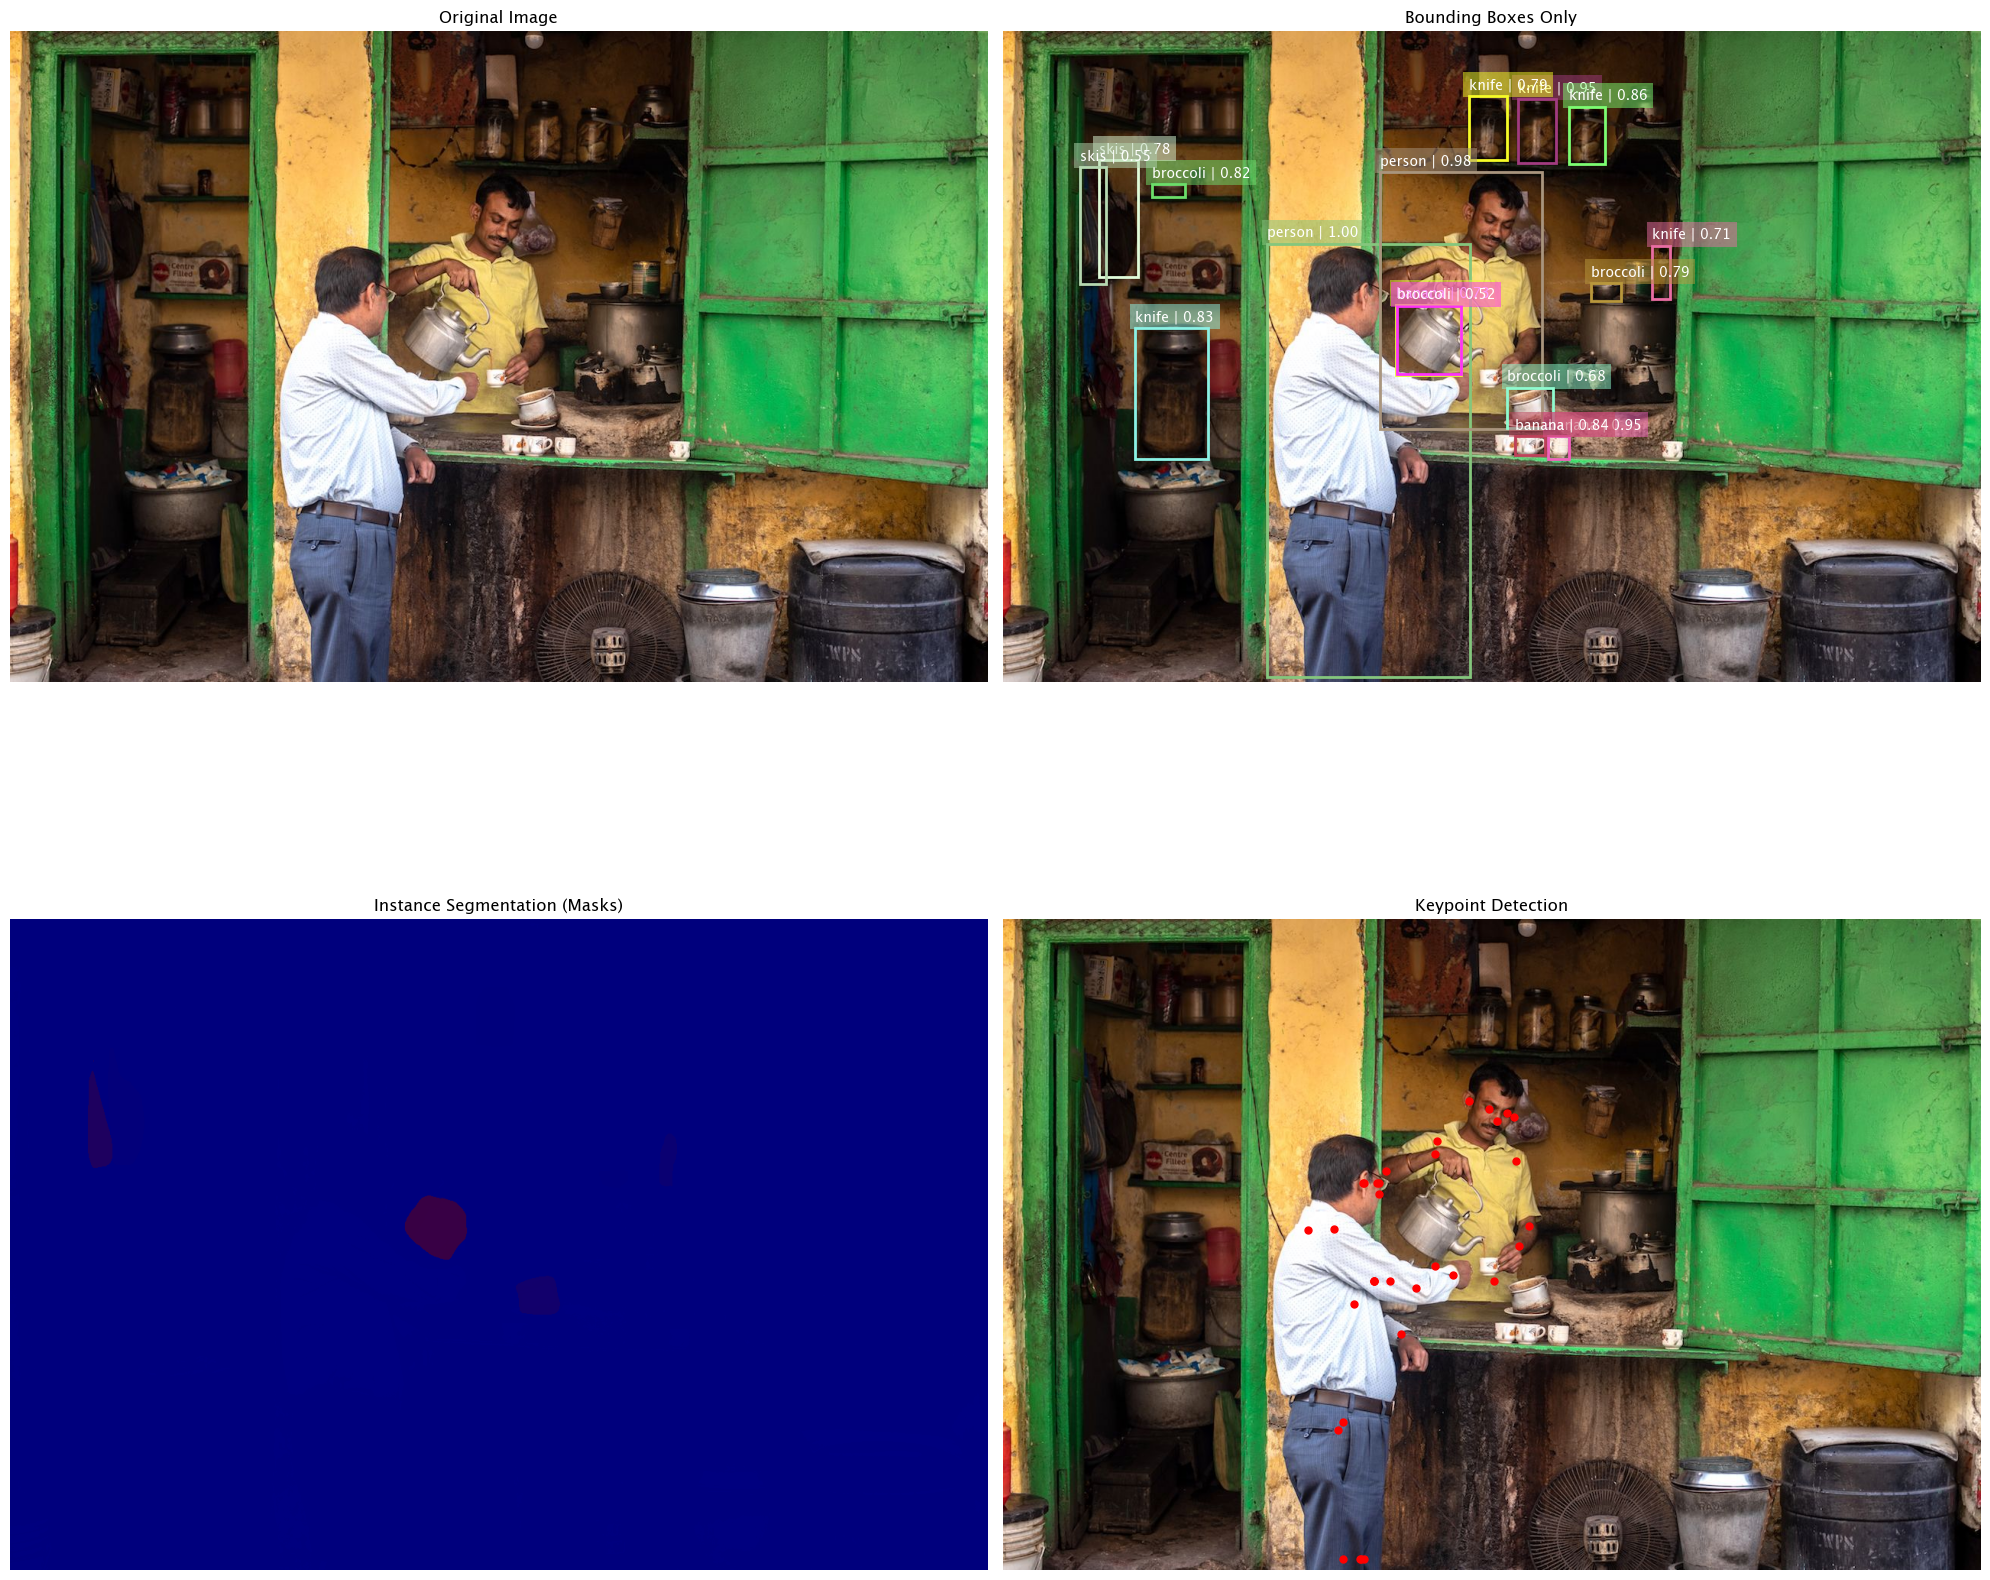

In [39]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn, keypointrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import requests
from io import BytesIO
from transformers import BlipProcessor, BlipForConditionalGeneration

# Define COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Load Mask R-CNN and Keypoint R-CNN models
mask_model = maskrcnn_resnet50_fpn(pretrained=True)
mask_model.eval()

keypoint_model = keypointrcnn_resnet50_fpn(pretrained=True)
keypoint_model.eval()

# Load BLIP captioning model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Image URL for testing
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert('RGB')
image_tensor = F.to_tensor(image)

# Perform inference for masks
with torch.no_grad():
    mask_prediction = mask_model([image_tensor])

# Perform inference for keypoints
with torch.no_grad():
    keypoint_prediction = keypoint_model([image_tensor])

# Extract bounding boxes, labels, masks, and keypoints
boxes = mask_prediction[0]['boxes']
labels = mask_prediction[0]['labels']
scores = mask_prediction[0]['scores']
masks = mask_prediction[0]['masks'] > 0.5

keypoints = keypoint_prediction[0]['keypoints']

# Generate a caption using BLIP
inputs = processor(image, return_tensors="pt")
with torch.no_grad():
    caption_output = caption_model.generate(**inputs)
caption = processor.decode(caption_output[0], skip_special_tokens=True)

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Original Image
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# 2. Bounding Boxes Only
axes[0, 1].imshow(image)
axes[0, 1].set_title("Bounding Boxes Only")
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Confidence threshold
        box = boxes[i]
        color = np.random.rand(3)  # Random color
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        axes[0, 1].add_patch(rect)
        class_name = COCO_INSTANCE_CATEGORY_NAMES[labels[i].item()]
        axes[0, 1].text(
            box[0],
            box[1] - 10,
            f"{class_name} | {scores[i]:.2f}",
            color='white',
            fontsize=10,
            bbox=dict(facecolor=color, alpha=0.5, edgecolor='none')
        )
axes[0, 1].axis('off')

# 3. Masks (Instance Segmentation)
axes[1, 0].imshow(image)
axes[1, 0].set_title("Instance Segmentation (Masks)")
for i in range(len(masks)):
    if scores[i] > 0.5:
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        color = np.random.rand(3)
        axes[1, 0].imshow(mask, alpha=0.4, cmap='jet')
axes[1, 0].axis('off')

# 4. Keypoints (Pose Estimation)
axes[1, 1].imshow(image)
axes[1, 1].set_title("Keypoint Detection")
for i in range(len(keypoints)):
    keypoint_set = keypoints[i].cpu().numpy()
    for x, y, visibility in keypoint_set:
        if visibility > 0:  # Only plot visible keypoints
            axes[1, 1].plot(x, y, 'ro', markersize=5)
axes[1, 1].axis('off')

# Print the caption
print("Caption:", caption)

# Display the visualization
plt.tight_layout()
plt.show()
